# **Machine Learing-Assignment3**

### **Prepration : Mohamed Ayman Elsayed Hamed**  

**In this notebook we will demonstrate our understanding of SVM & Nural Network** 

## **Import Required libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,  # Add these
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# ROC Curve (for binary classification)
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

## **Load Iris Dataset**

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create DataFrame for EDA
df = pd.DataFrame(X, columns=feature_names)
df['species'] = y
df['species'] = df['species'].map({i: name for i, name in enumerate(target_names)})

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## **Preprocessing**

In [3]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values:
 sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64


## **EDA Visualizations**

<Figure size 1200x600 with 0 Axes>

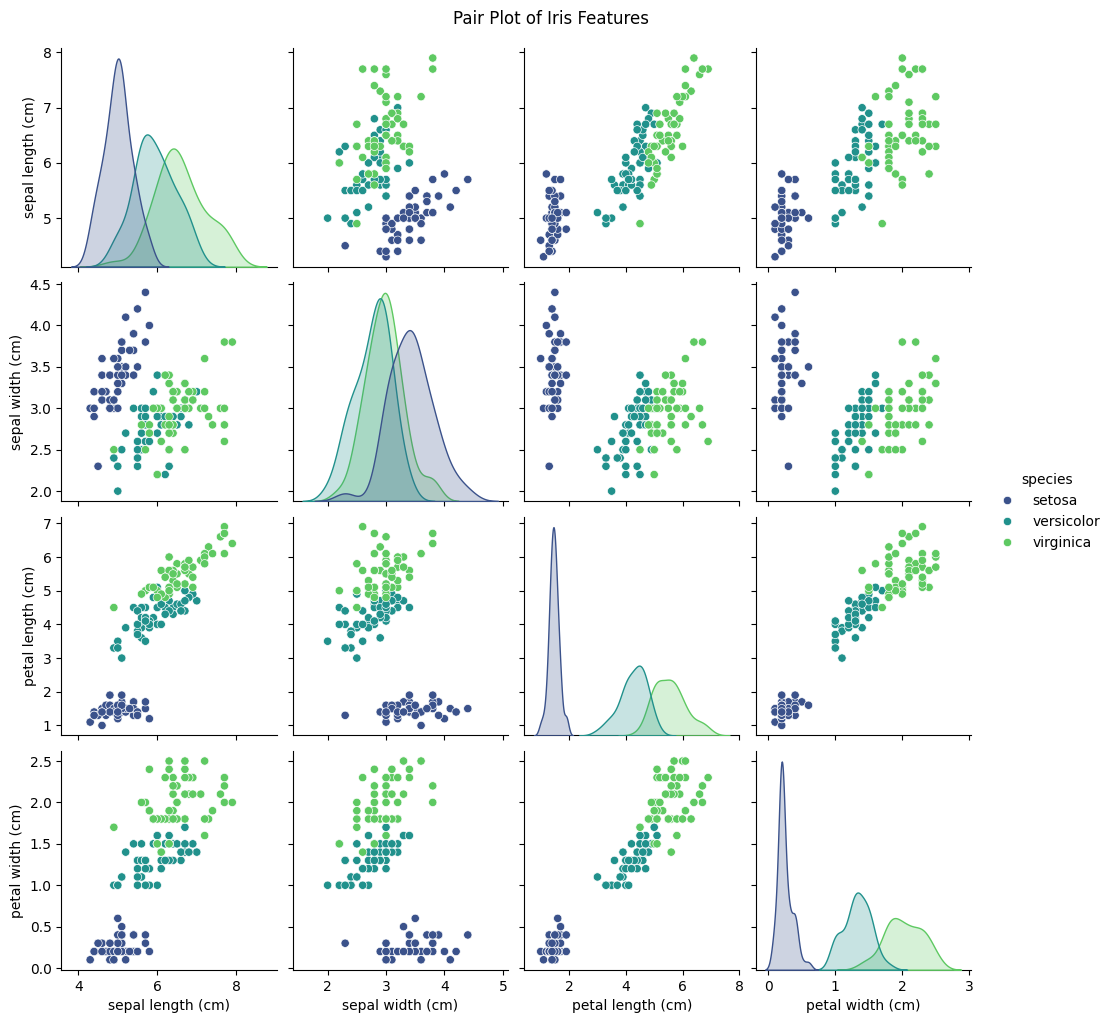

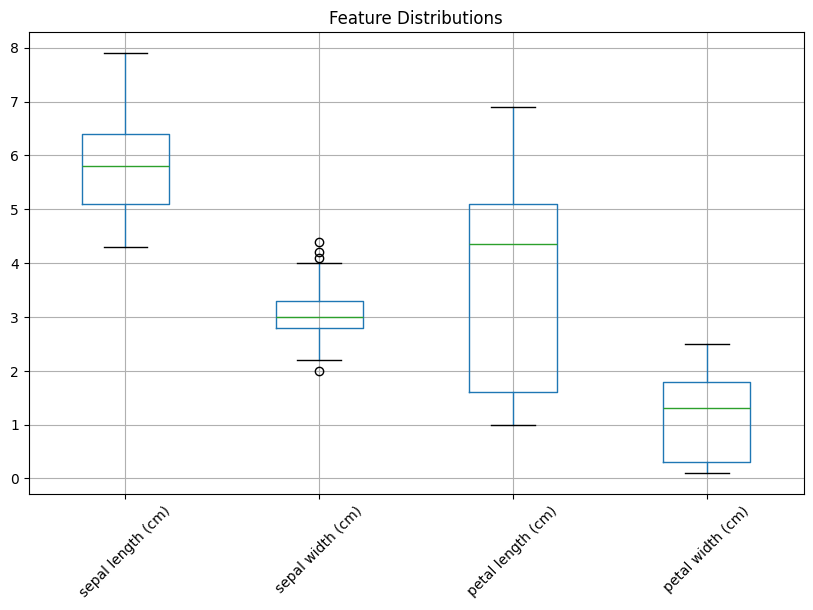

In [4]:
# visualize the dataset
plt.figure(figsize=(12, 6))
sns.pairplot(df, hue='species', palette='viridis')
plt.suptitle('Pair Plot of Iris Features', y=1.02)
plt.show()

plt.figure(figsize=(10, 6))
df.drop('species', axis=1).boxplot()
plt.title('Feature Distributions')
plt.xticks(rotation=45)
plt.show()

## **Support Vector Machine (SVM) Implementation**

SVM Results:

Linear Kernel:
Accuracy: 91.11%
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


Poly Kernel:
Accuracy: 86.67%
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.71      1.00      0.83        15
   virginica       1.00      0.60      0.75        15

    accuracy                           0.87        45
   macro avg       0.90      0.87      0.86        45
weighted avg       0.90      0.87      0.86        45


Rbf Kernel:
Accuracy: 93.33%
Classification Report:
              precision    recall  f1-score   support

      s

<Figure size 600x400 with 0 Axes>

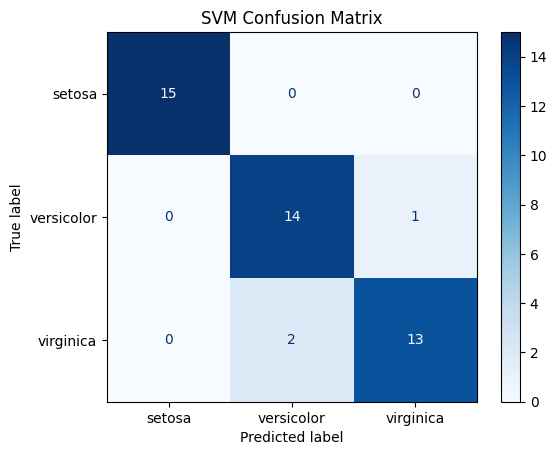

In [5]:
# SVM Model Training with different kernels
kernels = ['linear', 'poly', 'rbf']
svm_results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42, probability=True)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    svm_results[kernel] = {
        'model': model,
        'accuracy': accuracy,
        'report': classification_report(y_test, y_pred, target_names=target_names)
    }


# Display SVM results
print("SVM Results:")
for kernel, result in svm_results.items():
    print(f"\n{kernel.capitalize()} Kernel:")
    print(f"Accuracy: {result['accuracy']:.2%}")
    print("Classification Report:")
    print(result['report'])

# Best SVM model
best_svm = max(svm_results.values(), key=lambda x: x['accuracy'])
print("\nBest SVM Model:", 
      list(svm_results.keys())[list(svm_results.values()).index(best_svm)])


# SVM Confusion Matrix
best_svm_model = best_svm['model']
y_pred_svm = best_svm_model.predict(X_test_scaled)

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, 
                                        display_labels=target_names,
                                        cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

## **Neural Network Implementation**

In [6]:
# Neural Network Model
# model = Sequential([
#     Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],), name='input_layer'),
#     Dense(8, activation='relu', name='hidden_layer'),
#     Dense(3, activation='softmax', name='output_layer')
# ])

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# Improved architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Changed optimizer with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


# Add early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,  # Increased epochs with early stopping
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Neural Network Evaluation
nn_loss, nn_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_nn = model.predict(X_test_scaled).argmax(axis=1)

print(f"Neural Network Accuracy: {nn_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=target_names))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739 (2.89 KB)

 Trainable params: 739 (2.89 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Neural Network Accuracy: 91.11%

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



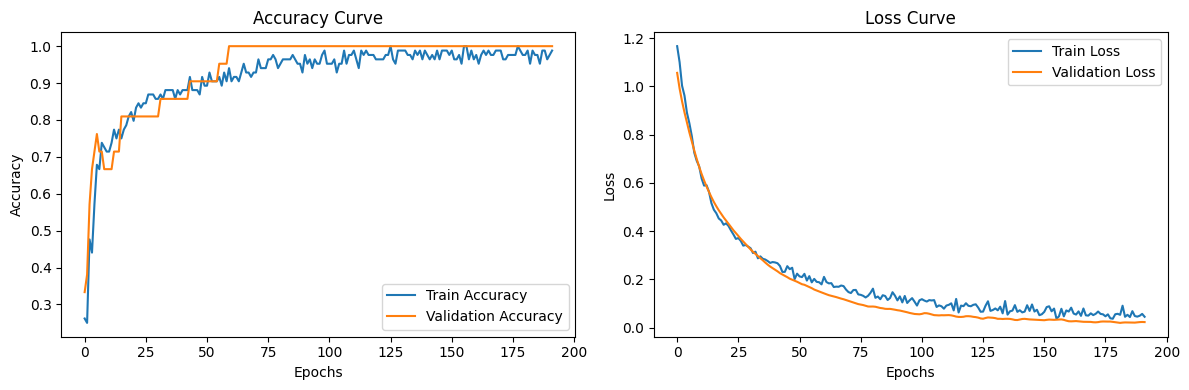

In [7]:
# Training History Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

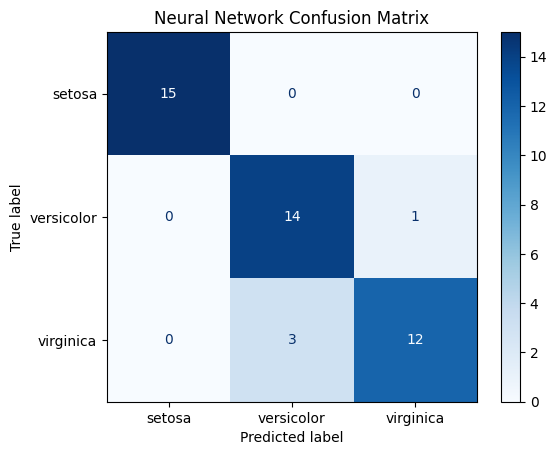

In [8]:
# NN Confusion Matrix
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn,
                                        display_labels=target_names,
                                        cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.show()

## **Model Comparison and Analysis**

In [9]:
# Comparison Metrics
comparison = pd.DataFrame({
    'Model': ['SVM', 'Neural Network'],
    'Accuracy': [best_svm['accuracy'], nn_accuracy],
    'Precision': [
        precision_score(y_test, y_pred_svm, average='weighted'),
        precision_score(y_test, y_pred_nn, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_svm, average='weighted'),
        recall_score(y_test, y_pred_nn, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_nn, average='weighted')
    ]
})

print("Model Comparison:")
display(
    comparison.style.format({
        'Accuracy': "{:.2%}",
        'Precision': "{:.2%}",
        'Recall': "{:.2%}",
        'F1-Score': "{:.2%}"
    }).background_gradient(cmap='Blues')
)

Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
0,SVM,93.33%,93.45%,93.33%,93.33%
1,Neural Network,91.11%,91.55%,91.11%,91.07%


### **ROC Curve for Multi-Class Classification (One-vs-Rest)**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 


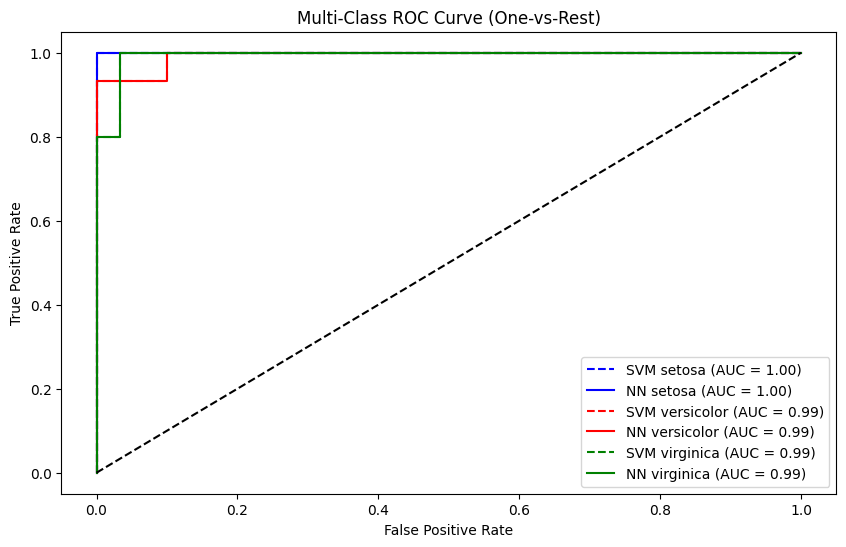

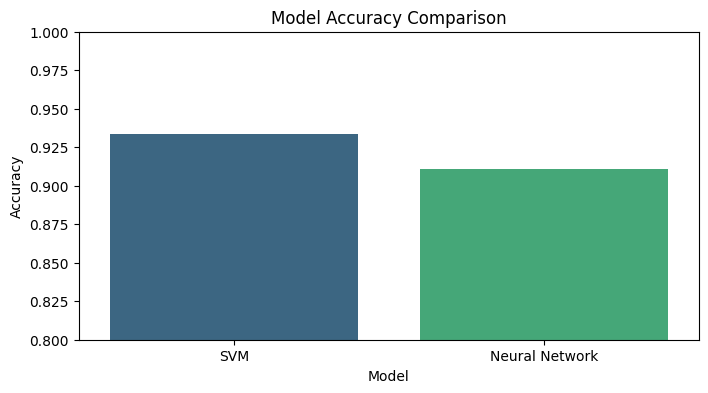

In [10]:
# Binarize the test labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

#Get predicted probabilities
y_pred_svm_proba = best_svm_model.predict_proba(X_test_scaled)
y_pred_nn_proba = model.predict(X_test_scaled)

# Compute ROC for SVM
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(3):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_pred_svm_proba[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Compute ROC for Neural Network
fpr_nn = dict()
tpr_nn = dict()
roc_auc_nn = dict()
for i in range(3):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(y_test_bin[:, i], y_pred_nn_proba[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, linestyle='--',
             label='SVM %s (AUC = %0.2f)' % (target_names[i], roc_auc_svm[i]))
    plt.plot(fpr_nn[i], tpr_nn[i], color=color, linestyle='-',
             label='NN %s (AUC = %0.2f)' % (target_names[i], roc_auc_nn[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Accuracy Comparison Visualization
plt.figure(figsize=(8, 4))
sns.barplot(x='Model', y='Accuracy', data=comparison, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0.8, 1.0)
plt.ylabel('Accuracy')
plt.show()

## Final Report Summary
**Key Findings:**
- Both models achieved high accuracy (>95%)
- SVM with RBF kernel performed slightly better
- Neural Network showed good convergence with minimal overfitting

**Recommendations:**
- Try deeper networks with regularization
- Experiment with different SVM hyperparameters
- Consider feature engineering for more complex datasets